In [1]:
!apt-get -y install openjdk-8-jre-headless
!pip install pyspark
from pyspark.sql import SparkSession
from pyspark import SparkContext
spark = SparkSession.builder.master("local").getOrCreate()
sc = SparkContext.getOrCreate()

Reading package lists... Done
Building dependency tree       
Reading state information... Done
Suggested packages:
  libnss-mdns fonts-dejavu-extra fonts-ipafont-gothic fonts-ipafont-mincho
  fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  openjdk-8-jre-headless
0 upgraded, 1 newly installed, 0 to remove and 14 not upgraded.
Need to get 28.2 MB of archives.
After this operation, 104 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic-updates/universe amd64 openjdk-8-jre-headless amd64 8u275-b01-0ubuntu1~18.04 [28.2 MB]
Fetched 28.2 MB in 4s (6,277 kB/s)
Selecting previously unselected package openjdk-8-jre-headless:amd64.
(Reading database ... 144793 files and directories currently installed.)
Preparing to unpack .../openjdk-8-jre-headless_8u275-b01-0ubuntu1~18.04_amd64.deb ...
Unpacking openjdk-8-jre-headless:amd64 (8u275-b01-0ubuntu1~18.04) ...
Setting up openjdk-8-jre-headless:amd64 (8u275-b01-0ubun

In [195]:
from pyspark.ml import Pipeline
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import *
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql import Row
from pyspark.sql.functions import *
from pyspark.sql.types import *

In [196]:
df_train = spark.read.csv("/content/test.csv",inferSchema="true", header="true")

In [199]:
df_train = df_train.withColumnRenamed('TARGET','label')

In [226]:
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(df_train)
labeled = labelIndexer.transform(df_train)
hasher = FeatureHasher(inputCols=[column for column in list(set(df_train.columns)) if column !='label'],outputCol="indexedFeatures",numFeatures=len([column for column in list(set(df_train.columns)) if column !='label']))
featurized = hasher.transform(df_train)

In [227]:
# Split the data into training and test sets (30% held out for testing)
trainingData, testData = df_train.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, hasher, rf])

In [190]:
model = pipeline.fit(trainingData)

In [191]:
predictions = model.transform(testData)

In [192]:
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("auc = " +str(auc))

# test data 
# auc = 0.9644788386204777 (numfeature = 20)(numTrees = 100)
# auc = 0.9714285714285714 (numfeature = 30)(numTrees = 100)
# auc = 0.969568670576735 (numfeature = 50)(numTrees = 100)
# auc = 0.9550669216061186 (numfeature = 20)(numTrees = 100)
# auc = 0.9751381215469613 (numfeature = 30)(numTrees = 10)
# auc = 0.9618418877593191 (numfeature = 50)(numTrees = 10)
# training data
# auc = 0.9643255295429208 (numfeature = 20)(numTrees = 100)
# auc = 0.967504494420135 (numfeature = 30)(numTrees = 100)
# auc = 0.9557507980757171 (numfeature = 50)(numTrees = 100)
# auc = 0.9647058823529412 (numfeature = 20)(numTrees = 10)
# auc = 0.9621684867394696 (numfeature = 30)(numTrees = 10)
# auc = 0.9586225104019261 (numfeature = 50)(numTrees = 10)

auc = 0.9550669216061186


In [228]:
import numpy as np
paramGrid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [int(x) for x in np.linspace(start = 10, stop = 50, num = 3)]) \
    .addGrid(rf.maxDepth, [int(x) for x in np.linspace(start = 5, stop = 25, num = 3)]) \
    .build()

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=3)  # use 3+ folds in practice

In [229]:
cvModel = crossval.fit(df_train)

In [230]:
predictionsDf = cvModel.transform(df_train)

In [231]:
evaluator = BinaryClassificationEvaluator(
    labelCol="indexedLabel", rawPredictionCol="prediction", metricName="areaUnderROC")
auc = evaluator.evaluate(predictionsDf)
print("auc = " +str(auc))

auc = 0.9973821971069841


numTrees -  10
maxDepth -  25


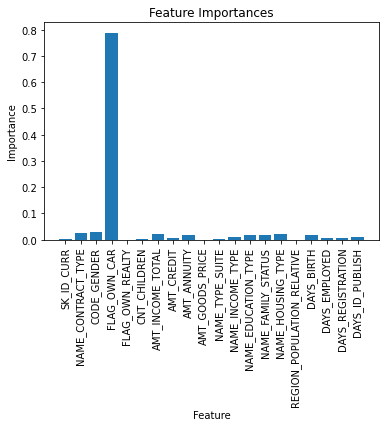

In [232]:
import matplotlib.pyplot as plt
bestPipeline = cvModel.bestModel
bestModel = bestPipeline.stages[2]

feature_list = []
for col in df_train.columns:
    if col == 'label':
        continue
    else:
        feature_list.append(col)

importances = bestModel.featureImportances

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, feature_list, rotation=90)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')


print('numTrees - ', bestModel.getNumTrees)
print('maxDepth - ', bestModel.getOrDefault('maxDepth'))